# My Changes
- [x] Random state 2 'seed' cell rather than fixed position 
    - [x] import random 
- [ ] merging of cells to spawn new states
- modified `prepare_augmenters()` to check if `dx` is a function, and if so to pass function
```
    dx_val = ap.get("dx", 0)
    dx = dx_val if callable(dx_val) else dx_val
```
- modified `run_augmenters` to run function in `dx` if not int, otherwise just use value


&nbsp;

#  The &nbsp; A C A &nbsp; l a b

(v. 3.0  2025-11-05)

&nbsp;

### A Jupyter Notebook laboratory for "Augmented" Cellular Automata"
### CSB195, Fall 2025
boris.steipe@utoronto.ca


&nbsp;

---
## What is this?
**ACA Lab** is a hands-on notebook for exploring **elementary cellular automata (ECA)** and for *augmenting* them with your own interventions. You can run classic Wolfram rules (0–255), and add small pieces of code that modify how the system **looks** (appearance) or, if you choose, how it **evolves** (state). 

## What does it do?
- **Core engine (Python/NumPy):** evolves a 1-D ECA (Elementary Cellular Automaton) on a ring or an interval (periodic or fixed boundaries).
- **One World ...:**  A "world" is defined by its width in 1-D, and the number of steps in time that it evolves.
- **... Two planes:**  
  - **State** (binary, 0/1) — this is the underlying reality, the states that are read and changed by the Wolfram rules.   
  - **Appearance** (palette indices) — this defines how the states appear. This plane can be recolored/annotated without changing the state.
- **Functions (Cell 2):** This needs to be run once. Then don't touch it again. It's technical. You probably won't need it to experiment with augmenters.
- **Initialization (Cell 3):** Only here are the parameters for the world defined.
- **Evolution (Cell 4):** The world evolves step by step here. But this is also where _augmenters_ are defined and spliced into the evolution. Once the required number of steps have been reached, the final state and hiostory of the world is visualized.
- **Visualization:**  
  - **Large trajectories** are written to an HTML page that is sent to the default browser.This makes them nimble, zoomable, and avoids Jupyter limitations on images. The HTML files are standalone - you can rename them and save them for later.
  - **Small diagnostic plots** are shown inline inside the notebook).

## How to use the notebook
1. Run **Cell 1** and **Cell 2**.
2. Define your world in **Cell 3** and run it.
3. Experiment with _augmenters_ in **CELL 4**, run Cell 4 each time to see their effect.
4. To evaluate the results, run analyses in **Cell 5** and **Cell 6**.

---


In [136]:
# =====================================================================
# CELL 1: Import required libraries, install missing, sanity check
# =====================================================================

import subprocess, sys, importlib

# External packages used in this notebook
REQUIRED_PACKAGES = ['numpy', 'matplotlib', 'tqdm']  

print(f"Checking for required packages: {', '.join(REQUIRED_PACKAGES)}...")

for package in REQUIRED_PACKAGES:
    try:
        importlib.import_module(package)
        print(f"'{package}' found.")
    except ImportError:
        print(f"'{package}' not found. Attempting installation...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"'{package}' installed successfully.")
        except Exception as e:
            print(f"ERROR: Could not install '{package}'. Please run 'python -m pip install {package}' manually.")
            raise e

# Final imports (after ensuring availability)
import numpy as np
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")  # inline figures in notebook
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from IPython.display import display

# Sanity info
print("All dependencies are ready.")
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)

# Simple capability check: filesystem writability
out_dir = Path("./ACA_outputs")
out_dir.mkdir(exist_ok=True)
print("Output directory:", out_dir.resolve())
print("Filesystem writable:", out_dir.exists() and out_dir.is_dir())


Checking for required packages: numpy, matplotlib, tqdm...
'numpy' found.
'matplotlib' found.
'tqdm' found.
All dependencies are ready.
NumPy: 2.3.4
Matplotlib: 3.10.7
Output directory: C:\Users\arjun\Documents\School\CSB195\src\py\ACA_outputs
Filesystem writable: True


In [ ]:
SPAWN_CELL_COUNT = 2

WIDTH  = 220           # spatial width (x)
STEPS  = 800     # number of time steps (y) -> results in STEPS+1 rows including t0
RANDOM_SEED = 8573444   # for reproducible randomness; set None for non-deterministic
global RANDOM_STEPS
RANDOM_STEPS = list(np.random.default_rng(RANDOM_SEED).integers(-1, 1, endpoint=True, size=STEPS*SPAWN_CELL_COUNT))
print(RANDOM_STEPS)

def get_next_step():
    return RANDOM_STEPS.pop(0)

[np.int64(0), np.int64(1), np.int64(0), np.int64(-1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(-1), np.int64(-1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(-1), np.int64(-1), np.int64(-1), np.int64(-1), np.int64(1), np.int64(1), np.int64(0), np.int64(-1), np.int64(0), np.int64(0), np.int64(-1), np.int64(0), np.int64(1), np.int64(1), np.int64(-1), np.int64(1), np.int64(1), np.int64(1), np.int64(-1), np.int64(-1), np.int64(-1), np.int64(0), np.int64(0), np.int64(-1), np.int64(0), np.int64(0), np.int64(-1), np.int64(1), np.int64(-1), np.int64(1), np.int64(0), np.int64(-1), np.int64(-1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(-1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(-1), np.int64(1), np.int64(0), np.int64(-1), np.int64(0), np.int64(1), np.int64(-1), np.int64(0), np.int64(1), np.int64(1), np.int64(-1), np.int64(0), np.int64(1), np.int64(1), n

In [138]:
# =====================================================================
# CELL 2: Helper functions (lots of)
# =====================================================================

from dataclasses import dataclass, asdict
from typing import Literal, Dict, Any
from pathlib import Path
import numpy as np
import json
import base64
import webbrowser, os


NeighborhoodOrderDoc = "Neighborhood bit ordering is 111,110,101,100,011,010,001,000 (Wolfram canonical)."

def rule_to_bitstring(rule: int) -> str:
    """
    Convert Wolfram ECA rule number (0..255) to an 8-char '0'/'1' bitstring.
    Order: 111,110,101,100,011,010,001,000 (MSB for '111').
    """
    if not (0 <= rule <= 255):
        raise ValueError("Rule must be in [0, 255].")
    return format(rule, '08b')


def bitstring_to_rule(bits: str) -> int:
    """
    Convert an 8-char '0'/'1' bitstring (ordered 111..000) to Wolfram rule int.
    """
    if len(bits) != 8 or any(c not in '01' for c in bits):
        raise ValueError("Bitstring must be 8 chars of '0'/'1'.")
    return int(bits, 2)

# Precompute mapping from neighborhood (3-bit index) to output for speed
def _rule_lookup(rule: int) -> np.ndarray:
    bits = rule_to_bitstring(rule)
    # map order 111..000 to integer indices 7..0
    return np.array([int(ch) for ch in bits], dtype=np.uint8)

def apply_rule(neighborhood: tuple[int, int, int], rule: int) -> int:
    """
    Core ECA transition for a single neighborhood.
    Any non-zero inputs are treated as 1.
    """
    l, c, r = (1 if x else 0 for x in neighborhood)  # booleanize
    idx = (l << 2) | (c << 1) | r                    # 0..7 for 111..000 is 7..0
    return int(_rule_lookup(rule)[7 - idx])          # flip to align 111..000

def make_lookup(rule: int) -> np.ndarray:
    """Precompute 8-bit lookup (ordered 111,110,...,000)."""
    return _rule_lookup(rule)

def eca_next(row: np.ndarray, boundary: str, lookup: np.ndarray) -> np.ndarray:
    """
    Vectorized one-step ECA update for an entire row.
    Any non-zero value in `row` counts as 1 (True) for rule evaluation.
    Returns uint8 array with values in {0,1}.
    """
    # --- PATCH: booleanize once, then build neighborhoods on the mask ---
    rb = (row != 0).astype(np.uint8)

    if boundary == 'periodic':
        L = np.roll(rb, +1); C = rb; R = np.roll(rb, -1)
    elif boundary == 'fixed':
        W = rb.shape[0]
        L = np.empty_like(rb); L[0]  = 0; L[1:]  = rb[:-1]
        C = rb
        R = np.empty_like(rb); R[-1] = 0; R[:-1] = rb[1:]
    else:
        raise ValueError("Unknown boundary. Use 'periodic' or 'fixed'.")

    # index 0..7 (00b..111b) computed from booleanized bits
    idx = (L << 2) | (C << 1) | R
    # lookup[0] == output for '111', lookup[7] for '000' → use 7-idx
    return lookup[7 - idx].astype(np.uint8)

# (nice-to-have convenience wrapper)
def eca_step(row: np.ndarray, rule: int, boundary: str = 'periodic') -> np.ndarray:
    """Convenience wrapper (uses booleanized evaluation as above)."""
    return eca_next(row, boundary, make_lookup(rule))


@dataclass               # Using the @dataclass "decorator" to simplify the creation of ...
class World:             # ... the class "World".
    width: int
    steps: int           # a state has steps+1 rows (including t0)
    rule: int            # the Wolfram code that makes this world
    boundary: Literal['periodic','fixed'] = 'periodic'
    seed: int | None = None
    init_mode: Literal['single_on_center','random'] = 'single_on_center'
    init_density: float = 0.5
    palette: Dict[int, str] | None = None
    # the two planes
    state: np.ndarray | None = None
    appearance: np.ndarray | None = None

    def __post_init__(self):
        # --- Require a palette (fail fast) ---
        if self.palette is None:
            raise ValueError(
                "World.palette is required. Define PALETTE in Cell 3 and pass it to World(...). "
                "Example: {0:'#FFFFFF', 1:'#427dae'}"
            )
        _validate_palette(self.palette)  # see helper below
        # Eagerly allocate arrays (the state- and appearance- planes)
        if self.state is None:
            self.state = np.zeros((self.steps + 1, self.width), dtype=np.uint8)
        if self.appearance is None:
            self.appearance = np.zeros((self.steps + 1, self.width), dtype=np.int16)

    # --- JSON (de)serialization helpers ---
def save_world_json(world: World, path: str | Path) -> Path:
    # unchanged usage; __post_init__ guarantees arrays exist
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open('w', encoding='utf-8') as f:
        json.dump(world.to_json_dict(), f)
    return p

def load_world_json(path: str | Path) -> World:
    with Path(path).open('r', encoding='utf-8') as f:
        d = json.load(f)
    w = World(
        width=int(d['width']),
        steps=int(d['steps']),
        rule=int(d['rule']),
        boundary=d.get('boundary', 'periodic'),
        seed=d.get('seed', None),
        init_mode=d.get('init_mode', 'single_on_center'),
        init_density=float(d.get('init_density', 0.5)),
        palette=d.get('palette', {0: "#FFFFFF", 1: "#427dae", 2: "#ffc107"})
    )
    # Overwrite with stored arrays
    w.state = np.array(d['state'], dtype=np.uint8)
    w.appearance = np.array(d['appearance'], dtype=np.int16)
    return w


def save_world_json(world: World, path: str | Path) -> Path:
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open('w', encoding='utf-8') as f:
        json.dump(world.to_json_dict(), f)
    return p

def load_world_json(path: str | Path) -> World:
    p = Path(path)
    with p.open('r', encoding='utf-8') as f:
        d = json.load(f)
    return World.from_json_dict(d)

# --- Validators ---
def _validate_palette(palette: dict[int, str]) -> None:
    if not isinstance(palette, dict):
        raise ValueError("Palette must be a dict mapping int -> hex color string.")
    for k, v in palette.items():
        if not isinstance(k, int):
            raise ValueError(f"Palette key {k!r} is not int.")
        if not (isinstance(v, str) and v.startswith('#') and len(v) in (7, 9)):
            raise ValueError(f"Palette value for key {k} must be '#RRGGBB' or '#RRGGBBAA', got {v!r}.")
        try:
            int(v[1:], 16)
        except Exception:
            raise ValueError(f"Palette color {v!r} is not valid hex.")
    # strictly require keys 0 and 1 
    required = {0, 1}
    missing = required - set(palette.keys())
    if missing:
        raise ValueError(f"Palette is missing required indices: {sorted(missing)}")


# --- HTML rendering: write a self-contained viewer and (optionally) open it ---
def render_html_view(world: World, out_html: str | Path) -> Path:
    import time, os

    t0 = time.perf_counter()
    
    # Choose byte width: 1 byte is enough if your palette indices < 256.
    max_index = int(np.max(world.appearance))
    dtype = np.uint8 if max_index < 256 else np.uint16
    appearance_flat = world.appearance.astype(dtype, copy=False).ravel(order="C")
    b64 = base64.b64encode(appearance_flat.tobytes()).decode("ascii")
    t1 = time.perf_counter()
    
    data_small = {
        "dtype": "u8" if dtype is np.uint8 else "u16",
        "width": world.width,
        "rows": world.steps + 1,
        "palette": world.palette,
        "meta": {
            "rule": world.rule,
            "boundary": world.boundary,
            "seed": world.seed,
            "init_mode": world.init_mode,
            "init_density": world.init_density
        }
    }
    html_template = f"""<!doctype html>
<html>
<head>
<meta charset="utf-8">
<title>ACA Trajectory (Rule {world.rule})</title>
<style>
  body {{ margin: 0; font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; }}
  #bar {{ padding: 8px 12px; display: flex; gap: 12px; align-items: center; border-bottom: 1px solid #ddd; }}
  #info {{ font-size: 14px; opacity: .8; }}
  #canvas {{ display: block; }}
  button, input {{ font-size: 14px; }}
  .mono {{ font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, monospace; }}
</style>
</head>
<body>
  <div id="bar">
    <span id="info"></span>
    <label>Scale: <input id="scale" type="number" step="1" min="1" value="6" style="width:60px;"></label>
    <button id="fit">Fit to window</button>
    <button id="square">Square pixels</button>
    <span class="mono">Palette: {json.dumps(world.palette)}</span>
  </div>
  <canvas id="canvas"></canvas>
  <script id="appearance_b64" type="application/octet-stream">
  {b64}
  </script>
<script>
const data = {json.dumps(data_small)};   
const canvas = document.getElementById('canvas');
const ctx = canvas.getContext('2d', {{alpha:false}});
const info = document.getElementById('info');
const scaleInput = document.getElementById('scale');

const rows = data.rows, cols = data.width, palette = data.palette;

// ---- decode base64 -> typed array (flat A of length rows*cols) ----

const b64 = document.getElementById('appearance_b64').textContent.trim();

function b64ToUint8(b64) {{
  const bin = atob(b64);
  const out = new Uint8Array(bin.length);
  for (let i = 0; i < bin.length; i++) out[i] = bin.charCodeAt(i);
  return out;
}}

console.time("decode");
const buf8 = b64ToUint8(b64);
const A = (data.dtype === "u8") ? buf8 : new Uint16Array(buf8.buffer);
console.timeEnd("decode");
console.log("A length:", (data.dtype==="u8"?buf8.length:new Uint16Array(buf8.buffer).length), "expected:", rows*cols);


// ---- palette packed to Uint32 (AABBGGRR in little-endian) ----
function hexToRgba(hex) {{
  hex = String(hex).trim().replace(/^#/, '');
  if (hex.length === 3)  hex = hex.split('').map(c => c+c).join('') + 'FF';
  else if (hex.length === 4) hex = hex.split('').map(c => c+c).join('');
  else if (hex.length === 6) hex += 'FF';
  if (hex.length !== 8) return [0,0,0,255];
  return [
    parseInt(hex.slice(0,2),16), parseInt(hex.slice(2,4),16),
    parseInt(hex.slice(4,6),16), parseInt(hex.slice(6,8),16)
  ];
}}
const maxKey = Math.max(...Object.keys(palette).map(k => parseInt(k,10)));
const pal32 = new Uint32Array(maxKey + 1);
for (const [k,v] of Object.entries(palette)) {{
  const [r,g,b,a] = hexToRgba(v);
  pal32[parseInt(k,10)] = (a<<24)|(b<<16)|(g<<8)|(r<<0);
}}

// ---- 1× base canvas + fast draw (then scale) ----
const base = document.createElement('canvas');
const bctx = base.getContext('2d', {{alpha:true}});
base.width = cols; base.height = rows;

function draw(scale) {{
  const img = bctx.createImageData(cols, rows);
  const buf32 = new Uint32Array(img.data.buffer);
  let p = 0;
  for (let y = 0; y < rows; y++) {{
    const rowOff = y * cols;
    for (let x = 0; x < cols; x++) {{
      buf32[p++] = pal32[A[rowOff + x]] || 0xFF000000;
    }}
  }}
  bctx.putImageData(img, 0, 0);

  canvas.width = cols * scale;
  canvas.height = rows * scale;
  ctx.imageSmoothingEnabled = false;
  ctx.drawImage(base, 0, 0, canvas.width, canvas.height);

  info.textContent = "Rule " + data.meta.rule +
                     " | boundary=" + data.meta.boundary +
                     " | seed=" + data.meta.seed +
                     " | init=" + data.meta.init_mode;
}}


document.getElementById('fit').addEventListener('click', () => {{
  const sX = Math.max(1, Math.floor(window.innerWidth / cols));
  const sY = Math.max(1, Math.floor((window.innerHeight-48) / rows));
  const s = Math.max(1, Math.min(sX, sY));
  scaleInput.value = s;
  draw(s);
}});

document.getElementById('square').addEventListener('click', () => {{
  const s = parseInt(scaleInput.value || '4', 10);
  draw(Math.max(1, s));
}});

scaleInput.addEventListener('change', () => {{
  const s = parseInt(scaleInput.value || '4', 10);
  draw(Math.max(1, s));
}});

console.time("draw");
draw(parseInt(scaleInput.value, 10));
console.timeEnd("draw");


</script>
</body>
</html>"""

    t2 = time.perf_counter()
    
    out_html = Path(out_html)
    out_html.parent.mkdir(parents=True, exist_ok=True)
    out_html.write_text(html_template, encoding='utf-8')

    size_kb = os.path.getsize(out_html) / 1024
    t3 = time.perf_counter()
    
    print(f"[render_html_view] b64: {(t1-t0)*1000:.1f} ms | template: {(t2-t1)*1000:.1f} ms | write: {(t3-t2)*1000:.1f} ms | size: {size_kb:.1f} KB")
    
    return out_html


def open_html(path: str | Path):
    """Try to open the given HTML file in a new browser tab/window (local setups)."""

    import time, webbrowser
    
    url = Path(path).resolve().as_uri()

    t0 = time.perf_counter()
    ok = webbrowser.open_new_tab(url)
    t1 = time.perf_counter()
    print(f"[open_html] launch: {(t1-t0)*1000:.1f} ms | ok={ok} | URL: {url}")
    print("Opened in browser:" if ok else "Could not auto-open; open manually:", url)

# --- Utility: prettify a rule ---
def describe_rule(rule: int) -> str:
    bits = rule_to_bitstring(rule)
    return f"Rule {rule} (bits {bits}) | {NeighborhoodOrderDoc}"

def parse_grid(g) -> np.ndarray:
    """
    Accepts:
      - "1011"  (1×W string)
      - "10\\n11" (H×W string, bottom line is 'now')
      - np.ndarray[int] (H×W or (W,) -> coerced to (1×W))
    Returns: int ndarray of shape (H, W) with values as given (no coercion to {0,1}).
    """
    if isinstance(g, np.ndarray):
        arr = g.astype(int, copy=False)
        if arr.ndim == 1:
            arr = arr[np.newaxis, :]
        elif arr.ndim != 2:
            raise ValueError("Grid ndarray must be 1D or 2D.")
        return arr
    if not isinstance(g, str):
        raise ValueError("Grid must be a string or numpy array.")
    # Split lines; ignore empty lines; bottom line is 'now'
    rows = [ln.strip() for ln in g.strip().splitlines() if ln.strip() != ""]
    if len(rows) == 1 and all(ch in "0123456789" for ch in rows[0]):
        data = [[int(ch) for ch in rows[0]]]
    else:
        data = [[int(ch) for ch in ln] for ln in rows]
    # Validate rectangular
    Wset = {len(r) for r in data}
    if len(Wset) != 1:
        raise ValueError("All grid rows must have same width.")
    return np.array(data, dtype=int)

def _candidate_anchors(width: int, patch_width: int, periodic: bool) -> np.ndarray:
    if periodic:
        return np.arange(width, dtype=int)
    # non-periodic: only anchors fully inside the segment
    max_start = width - patch_width
    if max_start < 0:
        return np.empty(0, dtype=int)
    return np.arange(max_start + 1, dtype=int)

def _slice_x(arr_row: np.ndarray, x0: int, w: int, periodic: bool) -> np.ndarray:
    """Return arr_row[x0:x0+w] with wrap if periodic; caller guarantees bounds otherwise."""
    W = arr_row.shape[0]
    if periodic:
        idx = (np.arange(x0, x0 + w) % W)
        return arr_row[idx]
    else:
        # out-of-bounds anchors must not be produced upstream
        return arr_row[x0:x0 + w]

def match_at_t(world, plane: str, t: int, pattern: np.ndarray) -> np.ndarray:
    """
    Find anchors x0 where pattern (H×W) matches rows [t-H+1 ... t] on the given plane.
    Inherits wrap from world.boundary. Returns int array of anchors (possibly empty).
    """
    if plane not in ("state", "appearance"):
        raise ValueError("plane must be 'state' or 'appearance'")
    pat = parse_grid(pattern)
    H, Wp = pat.shape
    if t + 1 < H:
        return np.empty(0, dtype=int)

    A = getattr(world, plane)  # shape (steps+1, width)
    width = world.width
    periodic = (world.boundary == 'periodic')

    anchors = _candidate_anchors(width, Wp, periodic)
    if anchors.size == 0:
        return anchors

    # Start with all candidates valid; knock out mismatches row by row
    ok = np.ones(anchors.shape[0], dtype=bool)
    # rows in the world corresponding to pattern rows (top..bottom) = (t-H+1 .. t)
    row_indices = range(t - H + 1, t + 1)

    for h, r in enumerate(row_indices):
        row = A[r]  # (width,)
        # Build window slices for all candidate anchors
        # windows[k] = row slice at anchor k (length Wp)
        if periodic:
            idx = (anchors[:, None] + np.arange(Wp)) % width  # shape (K, Wp)
            windows = row[idx]                                # shape (K, Wp)
            eq = np.all(windows == pat[h], axis=1)            # (K,)
        else:
            # In non-periodic, anchors already in-bounds
            # vectorized gather via broadcasting
            idx = anchors[:, None] + np.arange(Wp)            # (K, Wp)
            windows = row[idx]
            eq = np.all(windows == pat[h], axis=1)
        ok &= eq
        if not ok.any():
            return np.empty(0, dtype=int)
    return anchors[ok]

def match_at_row(world, plane: str, t_ref: int, pattern: np.ndarray) -> np.ndarray:
    """
    Find anchors x0 where pattern (H×W) matches rows [t_ref-H+1 ... t_ref] on plane.
    """
    if plane not in ("state", "appearance"):
        raise ValueError("plane must be 'state' or 'appearance'")
    pat = parse_grid(pattern)
    H, Wp = pat.shape
    if t_ref + 1 < H:
        return np.empty(0, dtype=int)

    A = getattr(world, plane)
    width = world.width
    periodic = (world.boundary == 'periodic')

    anchors = _candidate_anchors(width, Wp, periodic)
    if anchors.size == 0:
        return anchors

    ok = np.ones(anchors.shape[0], dtype=bool)
    for h, r in enumerate(range(t_ref - H + 1, t_ref + 1)):
        row = A[r]
        if periodic:
            idx = (anchors[:, None] + np.arange(Wp)) % width
            windows = row[idx]
        else:
            idx = anchors[:, None] + np.arange(Wp)
            windows = row[idx]
        ok &= np.all(windows == pat[h], axis=1)
        if not ok.any():
            return np.empty(0, dtype=int)
    return anchors[ok]

    
def apply_patch(world, plane: str, t: int, x0: int, patch: np.ndarray) -> None:
    """
    Overwrite rows [t-H+1 ... t], columns [x0 ... x0+W-1] with 'patch' (H×W).
    Wraps horizontally if world.boundary == 'periodic'. Fail-fast on invalid palette indices.
    """
    if plane not in ("state", "appearance"):
        raise ValueError("plane must be 'state' or 'appearance'")
    P = parse_grid(patch)
    H, Wp = P.shape
    if t + 1 < H:
        return  # not enough history yet
    A = getattr(world, plane)
    width = world.width
    periodic = (world.boundary == 'periodic')

    # Appearance palette coverage (fail-fast)
    if plane == "appearance":
        palette_keys = set(world.palette.keys())
        used = set(int(v) for v in np.unique(P))
        if not used.issubset(palette_keys):
            missing = sorted(used - palette_keys)
            raise ValueError(f"Appearance patch uses indices not in palette: {missing}")

    # Write row by row (vectorized along x via index arrays)
    for h, r in enumerate(range(t - H + 1, t + 1)):
        if periodic:
            idx = (np.arange(x0, x0 + Wp) % width)
            A[r, idx] = P[h]
        else:
            if x0 < 0 or x0 + Wp > width:
                # out-of-bounds anchors should not have been produced
                continue
            A[r, x0:x0 + Wp] = P[h]


# ---- World factory (fresh world from config) ----
def init_world() -> World:
    """(Re)initialize the World using globals defined in Cell 3."""
    global WIDTH, STEPS, RULE, BOUNDARY, RANDOM_SEED, INIT_MODE, INIT_DENSITY, PALETTE

    world = World(width=WIDTH, steps=STEPS, rule=RULE, boundary=BOUNDARY,
                  seed=RANDOM_SEED, init_mode=INIT_MODE,
                  init_density=INIT_DENSITY, palette=PALETTE)

    rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()
    
    if INIT_MODE == 'single_on_center':
        t0 = np.zeros(WIDTH, dtype=np.uint8)
        t0[WIDTH // 2] = 1
    elif INIT_MODE == 'random':
        if not (0.0 <= INIT_DENSITY <= 1.0):
            raise ValueError("INIT_DENSITY must be in [0,1].")
        t0 = (rng.random(WIDTH) < INIT_DENSITY).astype(np.uint8)
    else:
        raise ValueError(f"Unknown INIT_MODE: {INIT_MODE}")

    world.state[0] = t0
    world.appearance[0] = t0.astype(np.int16)

    print(describe_rule(RULE))
    print(f"World initialized: width={WIDTH}, steps={STEPS}, boundary={BOUNDARY}, "
          f"init={INIT_MODE}, seed={RANDOM_SEED}")
    return world


# ---- Prepare augmenters, merging pal_add with optional recolor ----
def prepare_augmenters(world: World, augs: list[dict]) -> list[dict]:
    prepped, additions = [], {}
    for i, spec in enumerate(augs):
        if not spec.get("enable", True):
            continue

        # palette additions (as before)
        for k, v in (spec.get("pal_add") or {}).items():
            k, v = int(k), str(v)
            if k in additions and additions[k] != v:
                raise ValueError(f"Augmenter {i} conflicts on palette[{k}]")
            additions[k] = v

        # normalize apply to a list
        applies = spec.get("apply")
        if isinstance(applies, dict):
            applies = [applies]
        if not isinstance(applies, list) or not applies:
            raise ValueError(f"Augmenter {i}: 'apply' must be a dict or nonempty list of dicts.")

        # parse grids & offsets
        m = spec["match"]
        pat = parse_grid(m["grid"])
        m_row_off = int(m.get("row_offset", 0))

        parsed_applies = []
        for a in applies:
            trg = a["grid"]
            if isinstance(trg, str) and len(trg) >= 2 and trg[0] in "+-" and trg[1:].isdigit():
                appl = pat + int(trg)
            else:
                appl = parse_grid(trg)
            if appl.shape != pat.shape and appl.shape != (1,1):
                # allow 1×1 “paint here” patches; otherwise shapes must match
                raise ValueError(f"Augmenter {i}: pattern/apply shape mismatch: {pat.shape} vs {appl.shape}")
            
            dx_val = a.get("x_offset", 0)
            dx = dx_val if callable(dx_val) else dx_val

            parsed_applies.append({
                "plane": a["plane"],
                "grid": appl,
                "row_offset": int(a.get("row_offset", 0)),
                "dx": dx, 
            })

        prepped.append({
            "match_plane": m["plane"],
            "pattern": pat,
            "match_row_offset": m_row_off,
            "applies": parsed_applies,
        })

    if additions:
        merged = {**world.palette, **additions}
        _validate_palette(merged)
        for k, v in additions.items():
            if k in world.palette and world.palette[k] != v:
                raise ValueError(f"Palette[{k}] already {world.palette[k]!r}, not {v!r}.")
        world.palette.update(additions)

    return prepped

def run_augmenters(world: World, t_now: int, prepared: list[dict]) -> None:
    for spec in prepared:
        t_match = t_now + spec.get("match_row_offset", 0)
        anchors = match_at_row(world, spec["match_plane"], t_match, spec["pattern"])
        if anchors.size == 0:
            continue
        periodic = (world.boundary == 'periodic')
        W = world.width
        for x0 in anchors.tolist():
            for ap in spec["applies"]:
                t_apply = t_now + ap.get("row_offset", 0)
                dx_val = ap.get("dx", 0)
                dx = int(dx_val()) if callable(dx_val) else int(dx_val)
                # dx = ap.get("dx", 0)
                x_apply = (x0 + dx) % W if periodic else (x0 + dx)
                # (Optional) guard fixed boundary writes that fall off the edge
                if not periodic and (x_apply < 0 or x_apply >= W):
                    continue
                apply_patch(world, ap["plane"], t_apply, x_apply, ap["grid"])                


In [139]:

# ================================================================
# CELL 3: World definition & initialization
# ================================================================

# Parameters (feel free to modify and re-run this cell)
RULE   = 110          # Wolfram code
BOUNDARY = 'fixed'     # 'periodic' or 'fixed'
INIT_MODE = 'random'   # currently only 'single_on_center' or 'random' are defined
INIT_DENSITY = 0.5    # used only for 'random'

# PALETTE with which to render the Appearance plane
# The palette must have as many states as the world.appearance plane contains.
# For default Wolfram codes, these are only ever states 0 and 1. But an augmenter
# could add any number of additional states into the appearance plane, as long
# as the palette has them too. Though it doesn't matter if the palette recognizes
# more states than are actually present in the appearance plane.
# Caution: the palette indices are stored as 1-byte, so you can't have more than
#          256 palette indices (unless you change the storage logic).
# The palette below is just an example ... you can freely edit it, and you can
# add custom colors with every augmenter.

PALETTE = {0: "#FFFFFF",   # state 0 -> OFF (white)
           1: "#800020",   # state 1 -> ON  (burgundy)
        #    2: "#1916CA",   # state 2 -> tbd
        #    3: "#D6E602"    # state 3 -> tbd
          }

print("Global parameters initialized.")


Global parameters initialized.


In [140]:

# ================================================================
# CELL 4: Processing — evolve the CA
#         This cell defines AUGMENTERS — small pattern-based rules
#         that AUGMENT the default ECA processing. Edit/experiment here.
# ================================================================
#
# PURPOSE
#   Define ACA "augmenters": after each Wolfram update, apply pattern
#   matches and overwrite selected regions in one or both planes.
#
# CONTEXT
#   The world has two planes, each a NumPy array of shape (steps+1, width):
#     - world.state      : integer states (row 0 is t0; increasing row = later time)
#     - world.appearance : integer palette indices used for rendering
#   Key World fields (from Cell 3 config):
#     - width, steps, rule, boundary, seed, init_mode, init_density, palette
#
# PROCESS
#   - At t0, state and appearance are initialized.
#   - For each t → t+1: compute the Wolfram update from world.state[t],
#     write the result into world.state[t+1] and mirror it to appearance[t+1].
#   - Then run all ENABLED augmenters in order; they may overwrite regions
#     in world.state and/or world.appearance (now and/or past rows).
#   - Repeat until STEPS updates are complete.
#
# CONTRACT 
#   - Engine helpers prepare_augmenters(...) and run_augmenters(...) exist (Cell 2).
#     They expect each augmenter to follow the schema below.
#   - world is freshly re-initialized when this cell runs.
#   - palette additions declared via "pal_add" are merged once (fail-fast on conflicts).
#   - Augmenters are applied in order, top→bottom; later writes win on conflicts.

# AUGMENTER SCHEMA
# {
#   "enable": True,                 # False disables this augmenter
#
#   "match": {
#       "plane": "state",           # "state" or "appearance" to scan
#       "grid":  "00101010",        # 1D "0101" or 2D with newlines; bottom row aligns to reference row
#       "row_offset": 0             # optional: match relative to now (t_now + row_offset). Use -1 to look at previous row.
#   },
#
#   "apply": [                      # one or more targets; a dict or a list of dicts (both allowed)
#     {
#       "plane": "appearance",      # "state" or "appearance" to modify
#       "grid":  "00000022000000",  # replacement pattern; must match shape of 'match.grid', or be "1"×"1"
#       "row_offset": 0,            # optional: write to t_now + row_offset (default 0 = now)
#       "x_offset": 0               # optional: shift write horizontally by +k cells (use +1 to paint the center of a 3-wide match)
#     }
#   ],
#
#   "pal_add": {2: "#f22e90"}       # optional: add palette indices required by 'appearance' writes (hex #RGB/#RGBA/#RRGGBB/#RRGGBBAA)
# }

# NOTES
#   • To suppress the Wolfram update entirely, set RULE = 0 in Cell 3.
#   • Wolfram update happens first each step: state[t+1] is computed from booleanized inputs (any nonzero is True) and mirrored to appearance[t+1].
#   • Augmenters run AFTER that; they may overwrite "now" (t+1) and/or past rows, never the future.
#   • You may specify apply grids as offsets, e.g. "+2" meaning (pattern + 2).
#   • For neighborhood logic using the previous row, set match.row_offset = -1 and apply.row_offset = 0.
#     Example: match "002" at t-1 and paint a single "2" at the match center now → apply with grid = "2" and x_offset = +1.
#   • Shapes: apply.grid must match match.grid shape, except we allow a 1×1 patch for “paint here” cases.
#   • Ordering: augmenters are evaluated in list order; if two write the same cell/time, the later one wins.
#   • Matching/apply grids must have identical shape; 1D vs 2D is supported.
#   • Augmentation occurs AFTER each ECA step; it can modify "now" (row t+1) or past rows.
#     Do not rely on writing the future (it will be overwritten by the next ECA step).
#   • Palette colors accept #RGB, #RGBA, #RRGGBB, or #RRGGBBAA hex; indices must exist
#     before writing to appearance (use pal_add).
#   • Fail-fast: invalid grids, shape mismatches, unknown palette indices, or conflicting pal_add colors raise clear errors.#
#
# ================================================================

import time

world = init_world()

# The two lines below seed a single cell with state 2. This is only needed for augmenters
# who test for that state, but it doesn't hurt other augmenters...
world.state[0, 107] = 2
world.appearance[0] = world.state[0].astype(np.int16)

AUGMENTERS = [
    # APPEARANCE MIRRORS
    
    {
        "enable":  True,
        "match":   {"plane": "state", "grid": "2", "row_offset": -1},
        "apply":   {"plane": "state", "grid": "2", 'x_offset': lambda: get_next_step()},
    },
    
    {
        'enable': False,
        'match': {'plane': 'state', 'grid': '001\n011\n111', 'rowoffset': -2},
        'apply': {'plane': 'state', 'grid': '002\n022\n222', 'rowoffset': 0},
        'pal_add': {2: '#1916CA'}
    },
    *[
      {
        "enable": False,
        "match": {"plane": "state", "grid": pat, "row_offset": -1},     # look at t-1
        "apply": {"plane": "state", "grid": '2', "row_offset": 0, "x_offset": 1},  # paint center at t
        'pal_add': {2: '#1916CA'}
      }
      # for pat in ["020","120","021","121"]  # Validation: extend state 2 in a single line
      for pat in ["002","020","210","012","021","102","120","201","022","202","220"]  # Rule 110
    ],
    {
        "enable": True,
        "match": {"plane": "state", "grid": "2"},
        "apply": {"plane": "appearance", "grid": "2"},
        'pal_add': {2: '#1916CA'}
    },

]


# --- The main method that evolves the world ---
def evolve(world: World, show_progress: bool = False) -> World:
    T = world.steps
    lookup = make_lookup(world.rule)
    prepared_augs = prepare_augmenters(world, AUGMENTERS)  # <- now in Cell 2

    iterator = range(T)
    if show_progress:
        from tqdm.auto import tqdm
        iterator = tqdm(iterator, desc="Evolving", leave=False)

    for t in iterator:
        prev = world.state[t]
        nxt  = eca_next(prev, world.boundary, lookup)

        world.state[t+1] = nxt
        world.appearance[t+1] = nxt.astype(np.int16)

        run_augmenters(world, t_now=t+1, prepared=prepared_augs)  # <- now in Cell 2

    return world

    
# --- Run the evolution and export the html that visualizes it ---
t0 = time.perf_counter()
evolve(world, show_progress=True)
print(f"evolve took {(time.perf_counter()-t0):.3f}s")


#evolve(world)
html_path = render_html_view(world, "./ACA_outputs/trajectory.html")
print("HTML written to:", Path(html_path).resolve())

# --- try to open the saved html directly from here
try:
    open_html(html_path)
except Exception as e:
    print("Could not auto-open HTML in browser:", e)


Rule 110 (bits 01101110) | Neighborhood bit ordering is 111,110,101,100,011,010,001,000 (Wolfram canonical).
World initialized: width=220, steps=800, boundary=fixed, init=random, seed=314195


Evolving:   0%|          | 0/800 [00:00<?, ?it/s]

evolve took 0.089s
[render_html_view] b64: 0.8 ms | template: 0.1 ms | write: 1.5 ms | size: 233.9 KB
HTML written to: C:\Users\arjun\Documents\School\CSB195\src\py\ACA_outputs\trajectory.html
[open_html] launch: 94.5 ms | ok=True | URL: file:///C:/Users/arjun/Documents/School/CSB195/src/py/ACA_outputs/trajectory.html
Opened in browser: file:///C:/Users/arjun/Documents/School/CSB195/src/py/ACA_outputs/trajectory.html


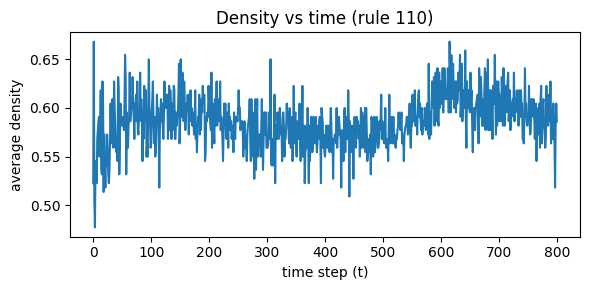

Saved: C:\Users\arjun\Documents\School\CSB195\src\py\ACA_outputs\density.png
Total fractional density over all cells and times: 0.586562251730791


In [141]:
# ================================================================
# CELL 5: Simple Analysis — density over time & total density
# ================================================================

import matplotlib.pyplot as plt

def density_per_step(world: World) -> np.ndarray:
    # mean of each row (fraction of '1's)
    return world.state.mean(axis=1)
    

def plot_density_vs_time(world: World, figsize=(6,3)):
    d = density_per_step(world)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(np.arange(d.shape[0]), d, linewidth=1.5)
    ax.set_xlabel("time step (t)")
    ax.set_ylabel("average density")
    ax.set_title(f"Density vs time (rule {world.rule})")
    fig.tight_layout()
    # Save small figure next to HTML for convenience    
    out_png = Path("./ACA_outputs/density.png")
    fig.savefig(out_png, dpi=150)
    display(fig)
    plt.close(fig)
    print("Saved:", out_png.resolve())

def total_fractional_density(world: World) -> float:
    return float(world.state.mean())

plot_density_vs_time(world)
print("Total fractional density over all cells and times:", total_fractional_density(world))



# Information-based analysis and Interpreation (Cell 6)

The cell below computes a small **complexity dashboard** for the spacetime produced by the augmented CA.  
We report both **booleanized** statistics (treat any nonzero state as “on”) and **label-aware** statistics (that track the alternate-rule process explicitly, e.g., state==2).

## What we compute (per time step unless noted)

**Densities**
- `on(t)`: fraction of cells with state > 0 (booleanized “on”).
- `p1(t)`, `p2(t)`: fractions with state==1 and state==2, respectively.
  - *Why:* Separates the background fabric (1) from the alt track (2). If `p2` quickly drops to 0, the alt process dies out.

**Entropy**
- `H_bin(t)`: binary Shannon entropy of the row after booleanization.
  - 0 for all-0/all-1 rows; 1 for a perfectly balanced random row.
- `H_multi(t)`: multiclass entropy over the actual labels {0,1,2,…}.
  - *Why:* `H_bin` detects order vs. noise; `H_multi` shows how much “surprise” is carried specifically by the alt label.

**Spatial correlation length**
- `corr_len_bool(t)`: first lag where the row’s autocorrelation (booleanized) drops below `1/e`.
- `corr_len_alt(t)`: same but on the indicator field `1(state==2)`.
  - *Why:* Ordered domains have longer correlations; pure chaos decorrelates quickly. Class-4 regimes often show **intermediate, time-varying** correlation scales.

**Alt-front geometry**
- `count_2(t)`, `width_2(t)`, `com_2(t)` (center-of-mass), and `xmin/xmax`.
  - *Why:* A quick readout of whether the alt process persists, spreads, drifts, or fragments.

**2D block entropy (rolling)**
- `H_{h,w}(t)`: entropy of distinct `h×w` blocks over the last `h` rows (default 8×8), booleanized.
  - *Why:* Captures **spatiotemporal** variety; it rises with local pattern diversity.  
    - Low in periodic/Class-2.  
    - High but featureless in Class-3.  
    - **Intermediate/high and slowly saturating** is a common Class-4 signature (domains + interactions).

**Compression ratio (rolling)**
- `R_cmp(t)`: zlib compressed size / raw size for the last `L` rows (default 64), booleanized.
  - *Why:* A proxy for global regularity.  
    - Periodic/frozen ⇒ **very compressible** (low ratio).  
    - Random ⇒ **incompressible** (high ratio).  
    - Class-4 often sits **between** (repeating scaffolds + novel interactions).

**Row-to-row mutual information**
- `I(row_t, row_{t+1})` on booleanized rows.
  - *Why:* Measures how much information about the next row is contained in the current row.  
    - Very low in near-random regimes (Class-3).  
    - High in periodic/fixed regimes (Class-1/2).  
    - **Moderate, structured** values that fluctuate are typical of Class-4.

---

## How to read the dashboard (rules: background + seeded alt)

1. **Alt dies out quickly**
   - `p2(t) → 0`, `count_2` and `width_2` collapse.
   - `H_bin` may rise (if background is chaotic) or fall (if background is periodic).
   - `H_{8,8}` low or plateaus quickly; `R_cmp` either very low (ordered) or very high (chaotic).
   - `corr_len_bool` either grows (ordered) or stays short (chaotic).

2. **Alt persists but locks into order**
   - `p2(t)` stabilizes near a constant; `width_2` bounded.
   - `H_bin` moderate/low; `H_{8,8}` modest; `R_cmp` trends **low** (compressible).
   - Correlation lengths non-zero and often stable → Class-2-ish coexistence.

3. **Alt coexists with background chaos**
   - `p2(t)` > 0 with variability; `width_2` wanders; `com_2` drifts.
   - `H_bin` high, but `R_cmp` not maximal (some structure); `H_{8,8}` high and varies.
   - `corr_len_bool` short on average; `corr_len_alt` may show intermittent bursts → mixed Class-3/4.

4. **“Interesting” Class-4-like dynamics**
   - `p2` persists; `width_2` fluctuates; fronts collide/shed.
   - `H_{8,8}` elevated and grows with window size before saturating; `R_cmp` intermediate.
   - `corr_len_bool` and `I(row_t,row_{t+1})` are neither minimal nor maximal, and often **oscillate**.
   - Visual tell: domains, gliders/particles, defect interactions visible in the HTML trajectory.

---

## Practical tips
- Always examine **booleanized** and **label-aware** curves together.  
  Booleanized metrics answer “Is there order or chaos?”; label-aware metrics answer “Is the *alt* process doing anything nontrivial?”
- For quick triage, a single scalar:
  \[
    \text{Score}(t) = H_{8,8}(t)\;\times\; \big(1 - R_\text{cmp}(t)\big)
  \]
  High values often flag Class-4-ish windows.
- Window sizes matter: increase `h,w` or `L` to probe **larger-scale** structure; decrease to detect **local** motifs.
- Keep boundary conditions in mind (periodic vs fixed) — they affect both correlation and compressibility.

---

### Caveat
These are **heuristics**, not formal classifiers. They’re designed to be fast, interpretable, and “hackable”. For deeper theory, one can add block-entropy growth (estimate entropy rate \(h_\mu\) and excess entropy \(E\)) or information-flow measures (transfer entropy), but the above set is usually enough to separate periodic, chaotic, and “interesting” regimes for this exploratory Notebook.

---

### Note
The explanations above are minimal. But together with the code they should definitely be sufficient to get detailed information about the measures and the rationale behind them from any well-constructed AI.


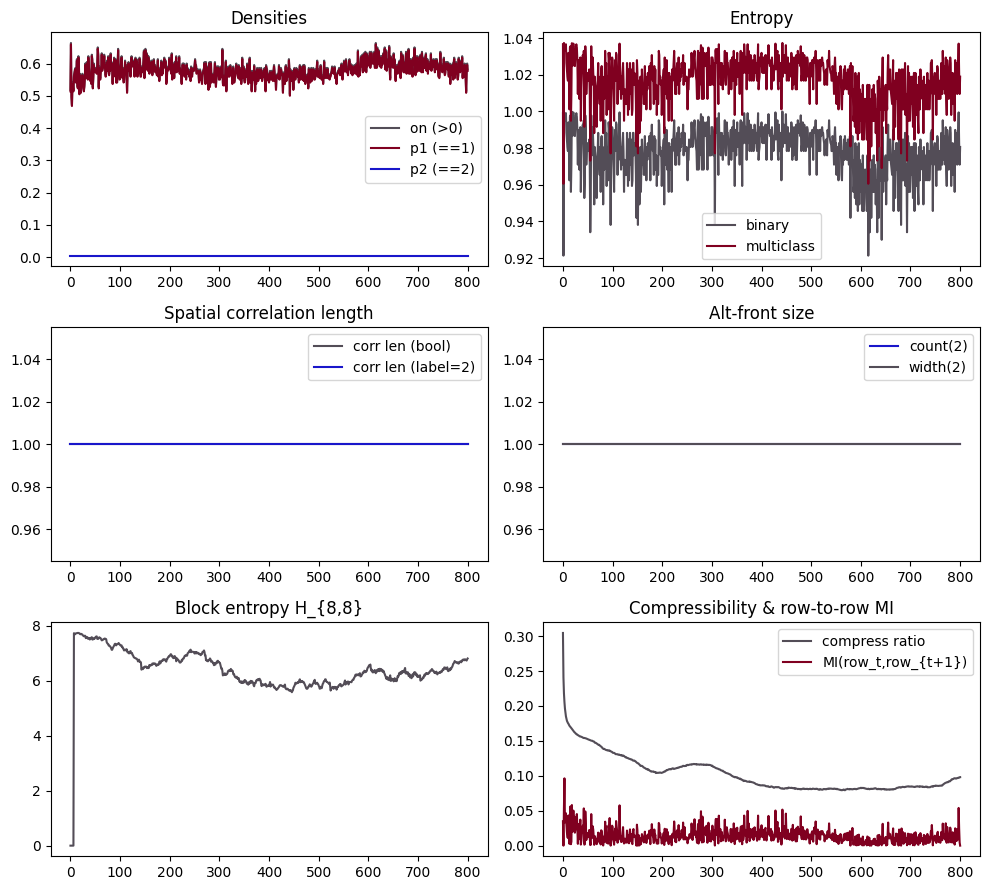

In [142]:
# ================================================================
# CELL 6: Complexity Analysis 
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import zlib

# colors, consistent with the pattern evolution
COL = {
    "state1": world.palette.get(1, "#427dae"),
    "state2": world.palette.get(2, "#dd0044"),
    "joint":  "#534D57",
    "on":     "#534D57",
}

# consistent line widths and alpha
LW  = 1.5
ALP = 1.0

def ts_density(world):
    X = world.state
    T = X.shape[0]
    on = (X > 0).mean(axis=1)
    p1 = (X == 1).mean(axis=1)
    p2 = (X == 2).mean(axis=1)
    return on, p1, p2

def ts_entropy(world):
    X = world.state
    B = (X > 0).astype(np.uint8)
    # binary entropy per row
    p = B.mean(axis=1)
    H_bin = np.where((p==0)|(p==1), 0.0, -(p*np.log2(p)+(1-p)*np.log2(1-p)))
    # multiclass entropy per row (over present labels)
    H_multi = np.empty(X.shape[0], dtype=float)
    for t,row in enumerate(X):
        vals, counts = np.unique(row, return_counts=True)
        ps = counts/row.size
        H_multi[t] = -np.sum(ps*np.log2(ps+1e-12))
    return H_bin, H_multi

def ts_corr_length(world, maxlag=128, label=None):
    """If label is None: booleanized; else: indicator for that label (e.g., 2)."""
    X = (world.state > 0).astype(np.float32) if label is None else (world.state == label).astype(np.float32)
    out = np.zeros(X.shape[0], dtype=float)
    for t,row in enumerate(X):
        r = row - row.mean()
        denom = float(np.dot(r, r)) + 1e-12
        cl = 0
        for lag in range(1, min(maxlag, row.size)):
            num = float(np.dot(r[:-lag], r[lag:]))
            if (num/denom) < 1/np.e:
                cl = lag; break
        out[t] = cl
    return out

def ts_alt_front(world, label=2):
    """Active count, min x, max x, width, center of mass for the alt label."""
    X = (world.state == label)
    T, W = X.shape
    count = X.sum(axis=1).astype(float)
    xmin = np.full(T, np.nan); xmax = np.full(T, np.nan)
    width = np.zeros(T, dtype=float); com = np.full(T, np.nan)
    xs = np.arange(W, dtype=float)
    for t in range(T):
        idx = np.flatnonzero(X[t])
        if idx.size:
            xmin[t], xmax[t] = idx[0], idx[-1]
            width[t] = xmax[t] - xmin[t] + 1
            com[t] = (idx.mean())
    return count, xmin, xmax, width, com

def block_entropy_last(world, h=8, w=8):
    """2D block entropy on the last h rows (booleanized); returns a scalar per time t >= h-1."""
    X = (world.state > 0).astype(np.uint8)
    T, W = X.shape
    if T < h or W < w:
        return np.zeros(T)
    from collections import Counter
    H = np.zeros(T)
    for t in range(h-1, T):
        slab = X[t-h+1:t+1]  # h×W
        counts = Counter()
        for x in range(0, W-w+1):
            counts[slab[:, x:x+w].tobytes()] += 1
        N = sum(counts.values())
        ps = np.fromiter((c/N for c in counts.values()), dtype=float)
        H[t] = float(-(ps*np.log2(ps+1e-12)).sum())
    return H

def compress_ratio_last(world, L=64):
    """Compression ratio on a rolling slab of the last L rows (booleanized)."""
    X = (world.state > 0).astype(np.uint8)
    T = X.shape[0]
    R = np.zeros(T)
    for t in range(T):
        a = max(0, t-L+1)
        slab = X[a:t+1]
        raw = slab.tobytes()
        comp = zlib.compress(raw, 6)
        R[t] = len(comp) / max(1, len(raw))
    return R

def mutual_info_rows(world, bins=2):
    """Plug-in MI between row t and t+1 on booleanized field."""
    B = (world.state > 0).astype(np.uint8)
    T, W = B.shape
    I = np.zeros(T)
    for t in range(T-1):
        x = B[t]; y = B[t+1]
        # joint counts
        joint = np.zeros((bins,bins), dtype=float)
        for a in (0,1):
            for b in (0,1):
                joint[a,b] = np.sum((x==a)&(y==b))
        joint /= W
        px = joint.sum(axis=1, keepdims=True)
        py = joint.sum(axis=0, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            m = joint * (np.log2(joint + 1e-12) - np.log2(px + 1e-12) - np.log2(py + 1e-12))
        I[t] = np.nansum(m)
    return I


on, p1, p2 = ts_density(world)
Hbin, Hmul = ts_entropy(world)
cl_bool = ts_corr_length(world)
cl_alt  = ts_corr_length(world, label=2)
cnt, xmin, xmax, width, com = ts_alt_front(world, label=2)
H88 = block_entropy_last(world, h=8, w=8)
Rcmp = compress_ratio_last(world, L=64)
Irow = mutual_info_rows(world)

fig, axs = plt.subplots(3,2, figsize=(10,9))
axs = axs.ravel()

axs[0].plot(on,  color=COL["on"],     lw=LW, alpha=ALP, label='on (>0)')
axs[0].plot(p1,  color=COL["state1"], lw=LW, alpha=ALP, label='p1 (==1)')
axs[0].plot(p2,  color=COL["state2"], lw=LW, alpha=ALP, label='p2 (==2)')
axs[0].set_title('Densities'); axs[0].legend()

axs[1].plot(Hbin, color=COL["joint"],  lw=LW, label='binary')
axs[1].plot(Hmul, color=COL["state1"], lw=LW, label='multiclass')
axs[1].set_title('Entropy'); axs[1].legend()

axs[2].plot(cl_bool, color=COL["joint"],  lw=LW, label='corr len (bool)')
axs[2].plot(cl_alt,  color=COL["state2"], lw=LW, label='corr len (label=2)')
axs[2].set_title('Spatial correlation length'); axs[2].legend()

axs[3].plot(cnt,   color=COL["state2"], lw=LW, label='count(2)')
axs[3].plot(width, color=COL["joint"],  lw=LW, label='width(2)')
axs[3].set_title('Alt-front size'); axs[3].legend()

axs[4].plot(H88,  color=COL["joint"], lw=LW); axs[4].set_title('Block entropy H_{8,8}')

axs[5].plot(Rcmp, color=COL["joint"],  lw=LW, label='compress ratio')
axs[5].plot(Irow, color=COL["state1"], lw=LW, label='MI(row_t,row_{t+1})')
axs[5].set_title('Compressibility & row-to-row MI'); axs[5].legend()

plt.tight_layout()
plt.show()


